In [1]:
from quafu import QuantumCircuit as quafuQC
from quark import Task
import sys
sys.path.append('/Users/brynn/work/gyb')
import gates
import tools
import experiments
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import random
# from random import randint

In [2]:
token = 'xRf`8jxdxfhTBLe3bE8liYPNwzi7ZgfVjlJrL.i1TPS/Rg3V{N1J{N35jN4ZEN4dEOzdUN7JDd5WnJtJjN2p{O2pkNzBDPz1zOx1DOzBkNjpkJ1GXbjxjJsinM1OYevR4Zm6ncwOHRnO3c2eXfjpkJzW3d2Kzf'

tmgr = Task(token)

In [3]:
chip = 'Baihua'
tmgr.status()

{'Dongling': 'Maintenance',
 'Miaofeng': 'Maintenance',
 'Baihua': 'Maintenance',
 'Yunmeng': 'Maintenance',
 'Haituo': 'Maintenance'}

### Map

/var/folders/z9/zsb0ck7s4bxd7nwf3h60xzxw0000gn/T/ipykernel_49800/3614713322.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/z9/zsb0ck7s4bxd7nwf3h60xzxw0000gn/T/ipykernel_49800/3614713322.py:94: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


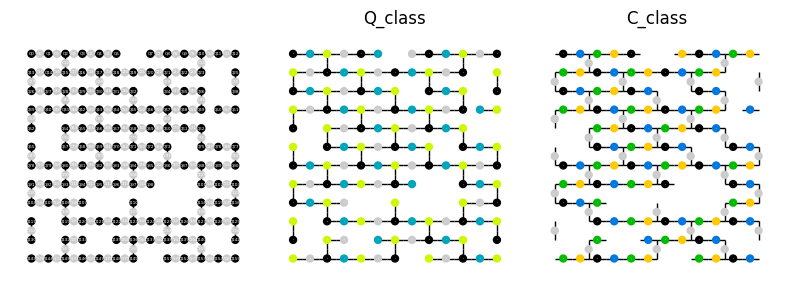

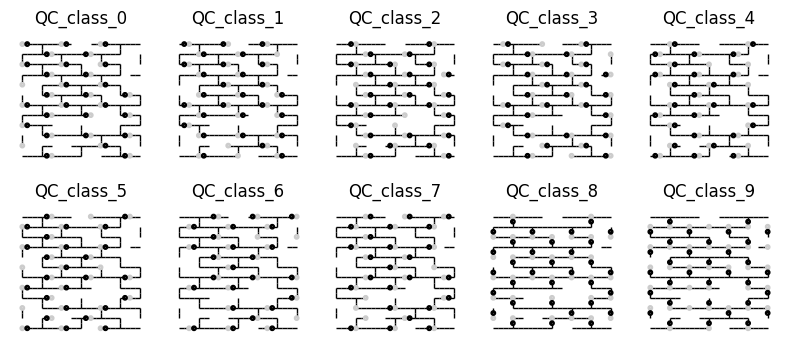

In [142]:
def _144V422_mapping(remove=[], plot=False, add_probe=False, tight=False, graph=None, pos=None):
    q_group, c_group = {i: [] for i in range(4)}, {i: [] for i in range(5)}
    qc_group = {i: [] for i in range(10)}
    if graph is None:
        from qos_tools.create.map import Mapping
        graph = Mapping()
    #     graph.cmap = 'diy'

        graph.add_qubits([f'Q{i*13+j}' for i in range(12) for j in range(13)])
        for q in graph.nodes:
            ii = eval(q[1:])
            graph.nodes[q]['Q_class'] = (((ii//13)%2*2)+(ii%13))%4
        pos = {f'Q{i*13+j}': np.array([j, -i]) for i in range(12) for j in range(13)}
        def _add_cp(c, q0, q1, pos=pos, graph=graph):
            graph.add_coupler(c, [q0, q1])
            pos[c] = (pos[q0]+pos[q1])/2
        cpl_start, cpl_step = [2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
        cnt = 0
        for i in range(12):
            for j in range(12):
                _add_cp(f'C{cnt}', f'Q{i*13+j}', f'Q{i*13+j+1}')
                graph.nodes[f'C{cnt}']['C_class'] = (j+i*2)%4
                cnt += 1
            if i<11:
                for j in range(cpl_start[i], 13, cpl_step[i]):
                    _add_cp(f'C{cnt}', f'Q{i*13+j}', f'Q{i*13+j+13}')
                    graph.nodes[f'C{cnt}']['C_class'] = 4
                    cnt += 1
        if add_probe:
            for i in range(12):
                graph.add_probe(f'M{i+1}', [f'Q{i*13+j}' for j in range(13)])
                pos[f'M{i+1}'] = np.array([-1, -i])
    new_remove = []
    for node in graph.nodes:
        if node[0]=='M':
            continue
        if tight:
            flag = True
            for q in graph.neighbors(node):
                if q in remove:
                    flag = False
                    break
            if not flag:
                new_remove.append(node)
    for node in remove+new_remove:
        if node in graph.nodes:
            graph.remove_node(node)
    new_remove = []
    for node in graph.nodes:
        if len(list(graph.neighbors(node)))==0:
            new_remove.append(node)
    for node in new_remove:
        graph.remove_node(node)
                    
    for node in graph.nodes:
        if node[0]=='Q':
            if graph.nodes[node]['Q_class'] in q_group:
                q_group[graph.nodes[node]['Q_class']].append(node)
        elif node[0]=='C':
            c_class_id = graph.nodes[node]['C_class']
            if c_class_id not in c_group:
                continue
            c_group[c_class_id].append(node)
            for qc in graph.neighbors(node):
                if qc[0]=='M':
                    continue
                qc_class_id = 2*c_class_id+eval(qc[1:])%2
                graph.nodes[qc][f'QC_class_{qc_class_id}'] = 1
                qc_group[qc_class_id].append((node, qc))
            graph.nodes[node][f"QC_class_{2*c_class_id}"] = 0.8
            graph.nodes[node][f"QC_class_{2*c_class_id+1}"] = 0.8
            
    if plot:
        fig, ax = plt.subplots(1, 3, figsize=[8, 3])
        ax = ax.flatten()

        graph.draw(pos=pos, ax=ax[0], font_size=3, node_size=25)
        graph.draw(pos=pos, ax=ax[1], tag='Q_class', colorbar=False, font_size=0, node_size=25)
        graph.draw(pos=pos, ax=ax[2], tag='C_class', colorbar=False, font_size=0, node_size=25)

        fig.tight_layout()
        fig.show()

        for name, cnt in [('QC', 10)]:

            fig, ax = plt.subplots((cnt+4)//5, 5, figsize=[8, (cnt+4)//5*1.8])
            ax = ax.flatten()

            for i in range(cnt):
                graph.draw(pos=pos, ax=ax[i], tag=f'{name}_class_{i}', colorbar=False, 
                           font_size=0, node_size=10)

            fig.tight_layout()
            fig.show()
        
    
    return graph, pos, q_group, c_group, qc_group

q_del = [
    'Q66', 'C78', # 这两个共用一根线，线不通
    'Q111', 'C130', # XY drive 衰减非常大    
    'C133', 'C117', 'C132', 'C56',
    'Q24','Q53','Q6','Q99','Q33','Q118','Q141','Q37','Q109','Q74','Q109',
    'Q63','Q64', # Ramsey差
    'Q134','Q131', # Ramsey忽然变得特别短
    'Q150', # amp一直在变
    'Q108'

]

graph, pos, q_group, c_group, qc_group = _144V422_mapping(
    plot=False, add_probe=False, tight=False, remove=[q for q in q_del if q[0]=='C'])
graph, pos, q_group, c_group, qc_group = _144V422_mapping(graph=graph, pos=pos,
    plot=True, add_probe=False, tight=True, remove=[q for q in q_del if q[0]=='Q'])

### cirs

In [76]:
xlist = [[], [((('Rx', 3.141592653589793), 0))],[((('Rx', 3.141592653589793), 1))], [((('Rx', 3.141592653589793), 0)),(('Rx', 3.141592653589793), 1)],]
mlist =  [[(('Measure', 0), 0)],[(('Measure', 0), 1)], [(('Measure', 0), 0), (('Measure', 1), 1)], ]
cirs = {i:xlist[i%4]+mlist[i//4] for i in range(12)}

In [110]:
cirs

{0: [(('Measure', 0), 0)],
 1: [(('Rx', 3.141592653589793), 0), (('Measure', 0), 0)],
 2: [(('Rx', 3.141592653589793), 1), (('Measure', 0), 0)],
 3: [(('Rx', 3.141592653589793), 0),
  (('Rx', 3.141592653589793), 1),
  (('Measure', 0), 0)],
 4: [(('Measure', 0), 1)],
 5: [(('Rx', 3.141592653589793), 0), (('Measure', 0), 1)],
 6: [(('Rx', 3.141592653589793), 1), (('Measure', 0), 1)],
 7: [(('Rx', 3.141592653589793), 0),
  (('Rx', 3.141592653589793), 1),
  (('Measure', 0), 1)],
 8: [(('Measure', 0), 0), (('Measure', 1), 1)],
 9: [(('Rx', 3.141592653589793), 0), (('Measure', 0), 0), (('Measure', 1), 1)],
 10: [(('Rx', 3.141592653589793), 1),
  (('Measure', 0), 0),
  (('Measure', 1), 1)],
 11: [(('Rx', 3.141592653589793), 0),
  (('Rx', 3.141592653589793), 1),
  (('Measure', 0), 0),
  (('Measure', 1), 1)]}

In [114]:
idles = {0:'0',
           1:'1',
           2:'0',
           3:'1',
           4:'0',
           5:'0',
           6:'1',
           7:'1',
           8:'00',
           9:'10',
           10:'01',
           11:'11'}

In [121]:
qubitss = [('Q0', 'Q1') ,
('Q4', 'Q5') ,
('Q8', 'Q9') ,
('Q15', 'Q16') ,
('Q19', 'Q20') ,
('Q26', 'Q27') ,
('Q30', 'Q31') ,
('Q34', 'Q35') ,
('Q41', 'Q42') ,
('Q45', 'Q46') ,
('Q56', 'Q57') ,
('Q60', 'Q61') ,
('Q67', 'Q68') ,
('Q71', 'Q72') ,
('Q75', 'Q76') ,
('Q78', 'Q79') ,
('Q82', 'Q83') ,
('Q86', 'Q87') ,
('Q93', 'Q94') ,
('Q97', 'Q98') ,
('Q101', 'Q102') ,
('Q104', 'Q105') ,
('Q119', 'Q120') ,
('Q123', 'Q124') ,
('Q127', 'Q128') ,
('Q138', 'Q139') ,
('Q145', 'Q146') ,
('Q153', 'Q154') ,
('Q1', 'Q2') ,
('Q9', 'Q10') ,
('Q16', 'Q17') ,
('Q20', 'Q21') ,
('Q27', 'Q28') ,
('Q31', 'Q32') ,
('Q35', 'Q36') ,
('Q42', 'Q43') ,
('Q46', 'Q47') ,
('Q50', 'Q51') ,
('Q57', 'Q58') ,
('Q61', 'Q62') ,
('Q68', 'Q69') ,
('Q72', 'Q73') ,
('Q76', 'Q77') ,
('Q79', 'Q80') ,
('Q83', 'Q84') ,
('Q87', 'Q88') ,
('Q94', 'Q95') ,
('Q102', 'Q103') ,
('Q105', 'Q106') ,
('Q120', 'Q121') ,
('Q124', 'Q125') ,
('Q128', 'Q129') ,
('Q135', 'Q136') ,
('Q139', 'Q140') ,
('Q146', 'Q147') ,
('Q154', 'Q155') ,
('Q2', 'Q3') ,
('Q10', 'Q11') ,
('Q13', 'Q14') ,
('Q17', 'Q18') ,
('Q21', 'Q22') ,
('Q28', 'Q29') ,
('Q39', 'Q40') ,
('Q43', 'Q44') ,
('Q47', 'Q48') ,
('Q54', 'Q55') ,
('Q58', 'Q59') ,
('Q69', 'Q70') ,
('Q80', 'Q81') ,
('Q84', 'Q85') ,
('Q88', 'Q89') ,
('Q91', 'Q92') ,
('Q95', 'Q96') ,
('Q106', 'Q107') ,
('Q114', 'Q115') ,
('Q121', 'Q122') ,
('Q125', 'Q126') ,
('Q132', 'Q133') ,
('Q136', 'Q137') ,
('Q143', 'Q144') ,
('Q147', 'Q148') ,
('Q151', 'Q152') ,
('Q3', 'Q4') ,
('Q7', 'Q8') ,
('Q11', 'Q12') ,
('Q14', 'Q15') ,
('Q18', 'Q19') ,
('Q22', 'Q23') ,
('Q29', 'Q30') ,
('Q40', 'Q41') ,
('Q44', 'Q45') ,
('Q48', 'Q49') ,
('Q55', 'Q56') ,
('Q59', 'Q60') ,
('Q70', 'Q71') ,
('Q81', 'Q82') ,
('Q85', 'Q86') ,
('Q89', 'Q90') ,
('Q92', 'Q93') ,
('Q96', 'Q97') ,
('Q107', 'Q108') ,
('Q115', 'Q116') ,
('Q122', 'Q123') ,
('Q126', 'Q127') ,
('Q137', 'Q138') ,
('Q144', 'Q145') ,
('Q148', 'Q149') ,
('Q152', 'Q153') ,
('Q2', 'Q15') ,
('Q10', 'Q23') ,
('Q13', 'Q26') ,
('Q17', 'Q30') ,
('Q21', 'Q34') ,
('Q25', 'Q38') ,
('Q28', 'Q41') ,
('Q32', 'Q45') ,
('Q36', 'Q49') ,
('Q39', 'Q52') ,
('Q43', 'Q56') ,
('Q47', 'Q60') ,
('Q54', 'Q67') ,
('Q58', 'Q71') ,
('Q62', 'Q75') ,
('Q65', 'Q78') ,
('Q69', 'Q82') ,
('Q73', 'Q86') ,
('Q77', 'Q90') ,
('Q80', 'Q93') ,
('Q84', 'Q97') ,
('Q88', 'Q101') ,
('Q91', 'Q104') ,
('Q95', 'Q108') ,
('Q103', 'Q116') ,
('Q106', 'Q119') ,
('Q110', 'Q123') ,
('Q114', 'Q127') ,
('Q117', 'Q130') ,
('Q125', 'Q138') ,
('Q129', 'Q142') ,
('Q132', 'Q145') ,
('Q136', 'Q149') ,
('Q140', 'Q153') ,]


qc_pair = {('Q0', 'Q1'): 'C0',
 ('Q4', 'Q5'): 'C4',
 ('Q8', 'Q9'): 'C8',
 ('Q15', 'Q16'): 'C17',
 ('Q19', 'Q20'): 'C21',
 ('Q26', 'Q27'): 'C31',
 ('Q30', 'Q31'): 'C35',
 ('Q34', 'Q35'): 'C39',
 ('Q41', 'Q42'): 'C48',
 ('Q45', 'Q46'): 'C52',
 ('Q56', 'Q57'): 'C66',
 ('Q60', 'Q61'): 'C70',
 ('Q67', 'Q68'): 'C79',
 ('Q71', 'Q72'): 'C83',
 ('Q75', 'Q76'): 'C87',
 ('Q78', 'Q79'): 'C93',
 ('Q82', 'Q83'): 'C97',
 ('Q86', 'Q87'): 'C101',
 ('Q93', 'Q94'): 'C110',
 ('Q97', 'Q98'): 'C114',
 ('Q101', 'Q102'): 'C118',
 ('Q104', 'Q105'): 'C124',
 ('Q119', 'Q120'): 'C141',
 ('Q123', 'Q124'): 'C145',
 ('Q127', 'Q128'): 'C149',
 ('Q138', 'Q139'): 'C163',
 ('Q145', 'Q146'): 'C172',
 ('Q153', 'Q154'): 'C180',
 ('Q1', 'Q2'): 'C1',
 ('Q9', 'Q10'): 'C9',
 ('Q16', 'Q17'): 'C18',
 ('Q20', 'Q21'): 'C22',
 ('Q27', 'Q28'): 'C32',
 ('Q31', 'Q32'): 'C36',
 ('Q35', 'Q36'): 'C40',
 ('Q42', 'Q43'): 'C49',
 ('Q46', 'Q47'): 'C53',
 ('Q50', 'Q51'): 'C57',
 ('Q57', 'Q58'): 'C67',
 ('Q61', 'Q62'): 'C71',
 ('Q68', 'Q69'): 'C80',
 ('Q72', 'Q73'): 'C84',
 ('Q76', 'Q77'): 'C88',
 ('Q79', 'Q80'): 'C94',
 ('Q83', 'Q84'): 'C98',
 ('Q87', 'Q88'): 'C102',
 ('Q94', 'Q95'): 'C111',
 ('Q102', 'Q103'): 'C119',
 ('Q105', 'Q106'): 'C125',
 ('Q120', 'Q121'): 'C142',
 ('Q124', 'Q125'): 'C146',
 ('Q128', 'Q129'): 'C150',
 ('Q135', 'Q136'): 'C160',
 ('Q139', 'Q140'): 'C164',
 ('Q146', 'Q147'): 'C173',
 ('Q154', 'Q155'): 'C181',
 ('Q2', 'Q3'): 'C2',
 ('Q10', 'Q11'): 'C10',
 ('Q13', 'Q14'): 'C15',
 ('Q17', 'Q18'): 'C19',
 ('Q21', 'Q22'): 'C23',
 ('Q28', 'Q29'): 'C33',
 ('Q39', 'Q40'): 'C46',
 ('Q43', 'Q44'): 'C50',
 ('Q47', 'Q48'): 'C54',
 ('Q54', 'Q55'): 'C64',
 ('Q58', 'Q59'): 'C68',
 ('Q69', 'Q70'): 'C81',
 ('Q80', 'Q81'): 'C95',
 ('Q84', 'Q85'): 'C99',
 ('Q88', 'Q89'): 'C103',
 ('Q91', 'Q92'): 'C108',
 ('Q95', 'Q96'): 'C112',
 ('Q106', 'Q107'): 'C126',
 ('Q114', 'Q115'): 'C134',
 ('Q121', 'Q122'): 'C143',
 ('Q125', 'Q126'): 'C147',
 ('Q132', 'Q133'): 'C157',
 ('Q136', 'Q137'): 'C161',
 ('Q143', 'Q144'): 'C170',
 ('Q147', 'Q148'): 'C174',
 ('Q151', 'Q152'): 'C178',
 ('Q3', 'Q4'): 'C3',
 ('Q7', 'Q8'): 'C7',
 ('Q11', 'Q12'): 'C11',
 ('Q14', 'Q15'): 'C16',
 ('Q18', 'Q19'): 'C20',
 ('Q22', 'Q23'): 'C24',
 ('Q29', 'Q30'): 'C34',
 ('Q40', 'Q41'): 'C47',
 ('Q44', 'Q45'): 'C51',
 ('Q48', 'Q49'): 'C55',
 ('Q55', 'Q56'): 'C65',
 ('Q59', 'Q60'): 'C69',
 ('Q70', 'Q71'): 'C82',
 ('Q81', 'Q82'): 'C96',
 ('Q85', 'Q86'): 'C100',
 ('Q89', 'Q90'): 'C104',
 ('Q92', 'Q93'): 'C109',
 ('Q96', 'Q97'): 'C113',
 ('Q107', 'Q108'): 'C127',
 ('Q115', 'Q116'): 'C135',
 ('Q122', 'Q123'): 'C144',
 ('Q126', 'Q127'): 'C148',
 ('Q137', 'Q138'): 'C162',
 ('Q144', 'Q145'): 'C171',
 ('Q148', 'Q149'): 'C175',
 ('Q152', 'Q153'): 'C179',
 ('Q2', 'Q15'): 'C12',
 ('Q10', 'Q23'): 'C14',
 ('Q13', 'Q26'): 'C27',
 ('Q17', 'Q30'): 'C28',
 ('Q21', 'Q34'): 'C29',
 ('Q25', 'Q38'): 'C30',
 ('Q28', 'Q41'): 'C43',
 ('Q32', 'Q45'): 'C44',
 ('Q36', 'Q49'): 'C45',
 ('Q39', 'Q52'): 'C58',
 ('Q43', 'Q56'): 'C59',
 ('Q47', 'Q60'): 'C60',
 ('Q54', 'Q67'): 'C74',
 ('Q58', 'Q71'): 'C75',
 ('Q62', 'Q75'): 'C76',
 ('Q65', 'Q78'): 'C89',
 ('Q69', 'Q82'): 'C90',
 ('Q73', 'Q86'): 'C91',
 ('Q77', 'Q90'): 'C92',
 ('Q80', 'Q93'): 'C105',
 ('Q84', 'Q97'): 'C106',
 ('Q88', 'Q101'): 'C107',
 ('Q91', 'Q104'): 'C120',
 ('Q95', 'Q108'): 'C121',
 ('Q103', 'Q116'): 'C123',
 ('Q106', 'Q119'): 'C136',
 ('Q110', 'Q123'): 'C137',
 ('Q114', 'Q127'): 'C138',
 ('Q117', 'Q130'): 'C151',
 ('Q125', 'Q138'): 'C153',
 ('Q129', 'Q142'): 'C154',
 ('Q132', 'Q145'): 'C167',
 ('Q136', 'Q149'): 'C168',
 ('Q140', 'Q153'): 'C169'}





In [80]:
cirs_df , tid_df = pd.DataFrame(columns = range(len(xlist)*len(mlist)), index=qubitss) , pd.DataFrame(columns = range(len(xlist)*len(mlist)), index=qubitss)

In [82]:
for qss in cirs_df.index:
    map = {0:qss[0], 1:qss[1]}
    for i in cirs_df.columns:
        cirs_df[i][qss] = tools.map_qlisp(cirs[i],map)

/var/folders/z9/zsb0ck7s4bxd7nwf3h60xzxw0000gn/T/ipykernel_49800/928903137.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cirs_df[i][qss] = tools.map_qlisp(cirs[i],map)


In [100]:
# 提交

# for i in cirs_df.columns:
#     for qss in cirs_df.index:

#         task = {
#             'chip':'Baihua',
#             'name':'gyb_read',
#             'circuit':cirs_df[i][qss],
#             'compile' : False, 
#         }


#         tid_df[i][qss] = tmgr.run(task, repeat=5)


/var/folders/z9/zsb0ck7s4bxd7nwf3h60xzxw0000gn/T/ipykernel_49800/1353917501.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tid_df[i][qss] = tmgr.run(task, repeat=5)


In [101]:
tid_df.to_csv('tids_read.csv')

In [103]:
tmgr.status(2408012006348757748)

'Pending'

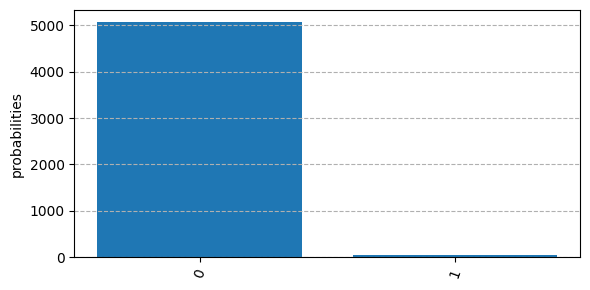

In [99]:
tools.plot_probabilities(tmgr.result(tid)['count'])

In [128]:
# 取数
count_df =  pd.DataFrame(columns = range(len(xlist)*len(mlist)), index=qubitss)
for i in count_df.columns:
    for qss in count_df.index:
        try:
            count_df[i][qss] = tmgr.result(tid_df[i][qss])['count']
        except:
            pass

[2024-08-01 21:34:00.806][QuarkCloud][CRITICAL💀] @SEND: NoneType[Errno 32] Broken pipe


/var/folders/z9/zsb0ck7s4bxd7nwf3h60xzxw0000gn/T/ipykernel_49800/1903227699.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  count_df[i][qss] = tmgr.result(tid_df[i][qss])['count']


In [129]:
count_df 

,0,1,2,3,4,5,6,7,8,9,10,11
"(Q0, Q1)","{'1': 66, '0': 5054}","{'1': 4882, '0': 238}","{'0': 5059, '1': 61}","{'1': 4911, '0': 209}","{'0': 5036, '1': 84}","{'0': 5023, '1': 97}","{'1': 4665, '0': 455}","{'1': 4637, '0': 483}","{'00': 4959, '10': 49, '01': 110, '11': 2}","{'10': 4794, '11': 137, '00': 188, '01': 1}","{'01': 4558, '00': 517, '11': 33, '10': 12}","{'11': 4474, '10': 409, '01': 218, '00': 19}"
"(Q4, Q5)","{'0': 5096, '1': 24}","{'1': 5023, '0': 97}","{'0': 5098, '1': 22}","{'1': 5021, '0': 99}","{'0': 4814, '1': 306}","{'0': 4805, '1': 315}","{'1': 4487, '0': 633}","{'1': 4185, '0': 935}","{'00': 4704, '01': 394, '10': 21, '11': 1}","{'10': 4641, '11': 366, '00': 104, '01': 9}","{'01': 4157, '00': 948, '11': 11, '10': 4}","{'10': 735, '11': 4263, '00': 19, '01': 103}"
"(Q8, Q9)","{'0': 5068, '1': 52}","{'1': 4883, '0': 237}","{'0': 5051, '1': 69}","{'0': 142, '1': 4978}","{'0': 5036, '1': 84}","{'0': 5055, '1': 65}","{'1': 4971, '0': 149}","{'1': 4971, '0': 149}","{'00': 4995, '01': 65, '10': 60}","{'10': 4820, '01': 40, '00': 236, '11': 24}","{'01': 4932, '00': 158, '11': 27, '10': 3}","{'01': 3829, '11': 1123, '10': 136, '00': 32}"
"(Q15, Q16)","{'0': 5048, '1': 72}","{'1': 4883, '0': 237}","{'0': 5040, '1': 80}","{'1': 4846, '0': 274}","{'0': 4954, '1': 166}","{'0': 4977, '1': 143}","{'1': 3804, '0': 1316}","{'0': 1317, '1': 3803}","{'00': 4915, '01': 145, '10': 58, '11': 2}","{'10': 4720, '00': 238, '11': 161, '01': 1}","{'00': 1099, '01': 3942, '11': 56, '10': 23}","{'11': 3703, '10': 1139, '01': 213, '00': 65}"
"(Q19, Q20)","{'0': 5095, '1': 25}","{'1': 4980, '0': 140}","{'0': 5082, '1': 38}","{'1': 5007, '0': 113}","{'0': 5079, '1': 41}","{'0': 5079, '1': 41}","{'1': 5020, '0': 100}","{'1': 4981, '0': 139}","{'00': 5028, '10': 35, '01': 57}","{'10': 4962, '11': 40, '00': 117, '01': 1}","{'01': 4944, '00': 131, '11': 44, '10': 1}","{'11': 4705, '10': 291, '01': 120, '00': 4}"
...,...,...,...,...,...,...,...,...,...,...,...,...
"(Q125, Q138)","{'0': 4939, '1': 181}","{'1': 4833, '0': 287}","{'1': 165, '0': 4955}","{'1': 4821, '0': 299}","{'0': 5035, '1': 85}","{'0': 5029, '1': 91}","{'1': 5011, '0': 109}","{'1': 5017, '0': 103}","{'01': 72, '00': 4878, '10': 167, '11': 3}","{'10': 4804, '00': 252, '11': 58, '01': 6}","{'01': 4852, '11': 168, '00': 98, '10': 2}","{'11': 4699, '01': 323, '10': 94, '00': 4}"
"(Q129, Q142)","{'0': 4942, '1': 178}","{'1': 4783, '0': 337}","{'0': 4926, '1': 194}","{'1': 4751, '0': 369}","{'0': 5082, '1': 38}","{'0': 5076, '1': 44}","{'1': 4945, '0': 175}","{'1': 4953, '0': 167}","{'00': 4901, '10': 181, '01': 36, '11': 2}","{'10': 4719, '00': 368, '11': 33}","{'01': 4747, '00': 159, '11': 200, '10': 14}","{'11': 4583, '01': 374, '10': 149, '00': 14}"
"(Q132, Q145)","{'0': 5084, '1': 36}","{'1': 4593, '0': 527}","{'0': 5083, '1': 37}","{'1': 4560, '0': 560}","{'0': 5071, '1': 49}","{'0': 5080, '1': 40}","{'1': 4570, '0': 550}","{'1': 4570, '0': 550}","{'00': 5040, '01': 52, '10': 28}","{'10': 4546, '00': 535, '11': 34, '01': 5}","{'01': 4610, '00': 493, '11': 17}","{'11': 4017, '01': 488, '10': 550, '00': 65}"
"(Q136, Q149)","{'0': 5085, '1': 35}","{'0': 493, '1': 4627}","{'0': 5080, '1': 40}","{'1': 4726, '0': 394}","{'0': 5071, '1': 49}","{'0': 5075, '1': 45}","{'1': 4801, '0': 319}","{'1': 4676, '0': 444}","{'00': 5031, '01': 52, '10': 37}","{'10': 4541, '11': 79, '00': 433, '01': 67}","{'01': 4678, '00': 400, '11': 38, '10': 4}","{'11': 4328, '10': 375, '01': 394, '00': 23}"


In [130]:
count_df.to_csv('count.csv')

In [131]:
vis_df =  pd.DataFrame(columns = range(len(xlist)*len(mlist)), index=qubitss)
for i in count_df.columns:
    for qss in count_df.index:
        try:
            vis_df[i][qss] = count_df[i][qss][idles[i]]/5120
        except:
            pass

/var/folders/z9/zsb0ck7s4bxd7nwf3h60xzxw0000gn/T/ipykernel_49800/1246140297.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vis_df[i][qss] = count_df[i][qss][idles[i]]/5120


In [132]:
vis_df

,0,1,2,3,4,5,6,7,8,9,10,11
"(Q0, Q1)",0.987109,0.953516,0.988086,0.95918,0.983594,0.981055,0.911133,0.905664,0.968555,0.936328,0.890234,0.873828
"(Q4, Q5)",0.995313,0.981055,0.995703,0.980664,0.940234,0.938477,0.876367,0.817383,0.91875,0.906445,0.811914,0.832617
"(Q8, Q9)",0.989844,0.953711,0.986523,0.972266,0.983594,0.987305,0.970898,0.970898,0.975586,0.941406,0.963281,0.219336
"(Q15, Q16)",0.985938,0.953711,0.984375,0.946484,0.967578,0.97207,0.742969,0.742773,0.959961,0.921875,0.769922,0.723242
"(Q19, Q20)",0.995117,0.972656,0.992578,0.97793,0.991992,0.991992,0.980469,0.972852,0.982031,0.969141,0.965625,0.918945
...,...,...,...,...,...,...,...,...,...,...,...,...
"(Q125, Q138)",0.964648,0.943945,0.967773,0.941602,0.983398,0.982227,0.978711,0.979883,0.952734,0.938281,0.947656,0.917773
"(Q129, Q142)",0.965234,0.93418,0.962109,0.92793,0.992578,0.991406,0.96582,0.967383,0.957227,0.92168,0.927148,0.895117
"(Q132, Q145)",0.992969,0.89707,0.992773,0.890625,0.99043,0.992188,0.892578,0.892578,0.984375,0.887891,0.900391,0.78457
"(Q136, Q149)",0.993164,0.903711,0.992188,0.923047,0.99043,0.991211,0.937695,0.913281,0.982617,0.886914,0.913672,0.845313


In [133]:
cs = []
for qss in vis_df.index:
    cs.append(qc_pair[qss])
vis_df.index = cs

In [134]:
vis_df

,0,1,2,3,4,5,6,7,8,9,10,11
C0,0.987109,0.953516,0.988086,0.95918,0.983594,0.981055,0.911133,0.905664,0.968555,0.936328,0.890234,0.873828
C4,0.995313,0.981055,0.995703,0.980664,0.940234,0.938477,0.876367,0.817383,0.91875,0.906445,0.811914,0.832617
C8,0.989844,0.953711,0.986523,0.972266,0.983594,0.987305,0.970898,0.970898,0.975586,0.941406,0.963281,0.219336
C17,0.985938,0.953711,0.984375,0.946484,0.967578,0.97207,0.742969,0.742773,0.959961,0.921875,0.769922,0.723242
C21,0.995117,0.972656,0.992578,0.97793,0.991992,0.991992,0.980469,0.972852,0.982031,0.969141,0.965625,0.918945
...,...,...,...,...,...,...,...,...,...,...,...,...
C153,0.964648,0.943945,0.967773,0.941602,0.983398,0.982227,0.978711,0.979883,0.952734,0.938281,0.947656,0.917773
C154,0.965234,0.93418,0.962109,0.92793,0.992578,0.991406,0.96582,0.967383,0.957227,0.92168,0.927148,0.895117
C167,0.992969,0.89707,0.992773,0.890625,0.99043,0.992188,0.892578,0.892578,0.984375,0.887891,0.900391,0.78457
C168,0.993164,0.903711,0.992188,0.923047,0.99043,0.991211,0.937695,0.913281,0.982617,0.886914,0.913672,0.845313


In [135]:
vis_df.to_csv('vis.csv')

In [155]:
cirs

{0: [(('Measure', 0), 0)],
 1: [(('Rx', 3.141592653589793), 0), (('Measure', 0), 0)],
 2: [(('Rx', 3.141592653589793), 1), (('Measure', 0), 0)],
 3: [(('Rx', 3.141592653589793), 0),
  (('Rx', 3.141592653589793), 1),
  (('Measure', 0), 0)],
 4: [(('Measure', 0), 1)],
 5: [(('Rx', 3.141592653589793), 0), (('Measure', 0), 1)],
 6: [(('Rx', 3.141592653589793), 1), (('Measure', 0), 1)],
 7: [(('Rx', 3.141592653589793), 0),
  (('Rx', 3.141592653589793), 1),
  (('Measure', 0), 1)],
 8: [(('Measure', 0), 0), (('Measure', 1), 1)],
 9: [(('Rx', 3.141592653589793), 0), (('Measure', 0), 0), (('Measure', 1), 1)],
 10: [(('Rx', 3.141592653589793), 1),
  (('Measure', 0), 0),
  (('Measure', 1), 1)],
 11: [(('Rx', 3.141592653589793), 0),
  (('Rx', 3.141592653589793), 1),
  (('Measure', 0), 0),
  (('Measure', 1), 1)]}

In [178]:
i = 8
read_vis = {}
for c in vis_df.index:
    read_vis[c] = vis_df[i][c]

## plot

In [179]:
for q in graph:
    if q[0]=='C':
        graph.nodes[q]['read'] = read_vis[q]

/var/folders/z9/zsb0ck7s4bxd7nwf3h60xzxw0000gn/T/ipykernel_49800/2866584755.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


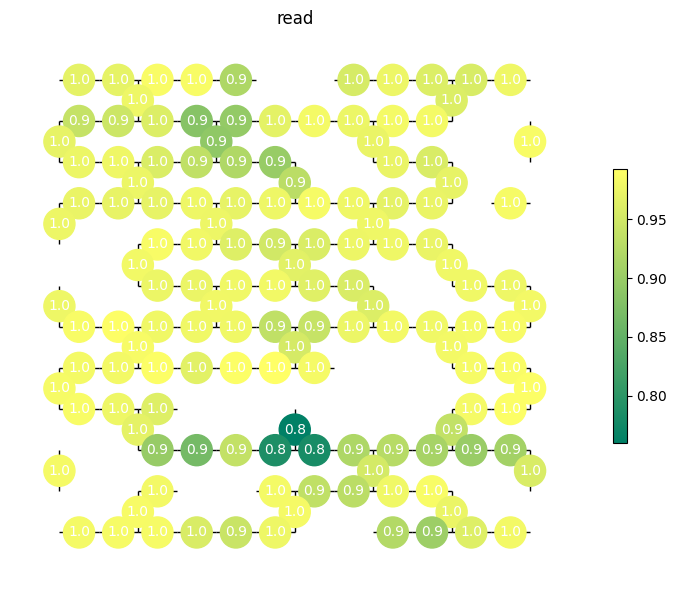

In [181]:
fig, ax = plt.subplots(figsize=[7, 6])

graph.cmap = 'summer'
graph.draw(pos=pos, ax=ax, tag='read', colorbar=True, font_size=10, node_size=500, ndim=1)


fig.tight_layout()
fig.show()

In [164]:

qmap, chip = {0:'Q81', 1:'Q82'}, 'Baihua'
circ,qlisp = quafuQC(2), []
gates.add_R('Rx', qlisp, circ, np.pi, 0)
gates.add_R('Rx', qlisp, circ, np.pi, 1)

gates.add_measure(qlisp, circ, [0])


qlisp = tools.map_qlisp(qlisp,qmap)
qlisp

[(('Rx', 3.141592653589793), 'Q81'),
 (('Rx', 3.141592653589793), 'Q82'),
 (('Measure', 0), 'Q81')]

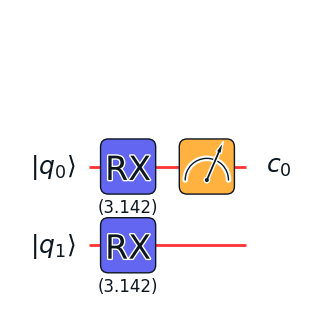

In [165]:
circ.plot_circuit()

In [166]:
from waveforms import drag

In [167]:
drag?

Signature: drag(freq, width, plateau=0, delta=0, block_freq=None, phase=0, t0=0)
Docstring: <no docstring>
File:      /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/waveforms/waveform.py
Type:      function

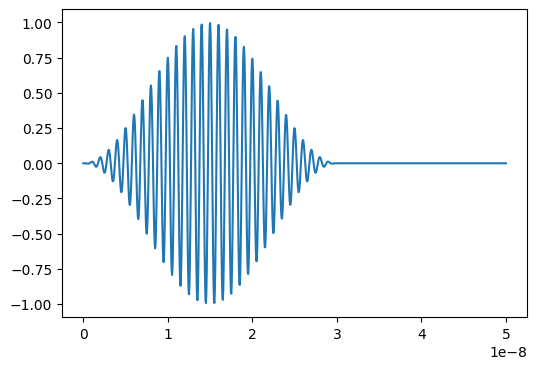

In [174]:
fig, ax = plt.subplots(figsize=[6, 4])
d = drag(freq = 1e9, width=3e-8, plateau=0, delta=0, block_freq=None, phase=0, t0=0)
t = np.linspace(0,5e-8,1000)
ax.plot(t, d(t))

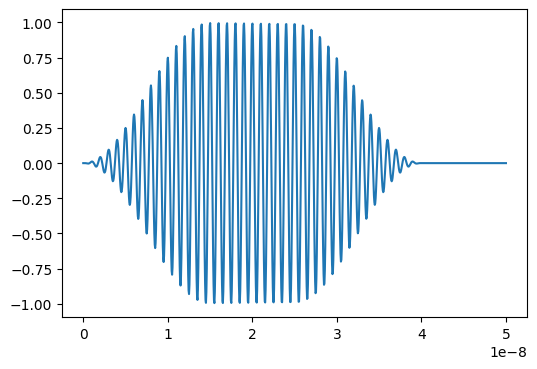

In [173]:
fig, ax = plt.subplots(figsize=[6, 4])
d = drag(freq = 1e9, width=3e-8, plateau=1e-8, delta=0.5e-8, block_freq=None, phase=0, t0=0)
t = np.linspace(0,5e-8,1000)
ax.plot(t, d(t))

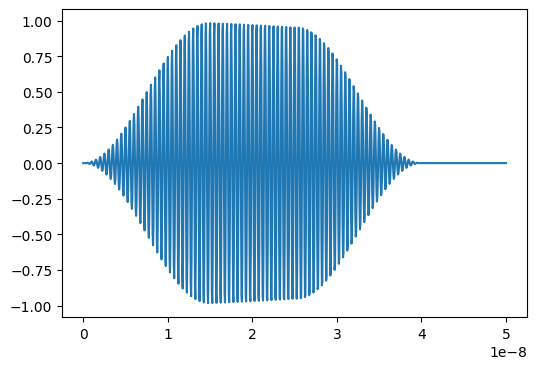

In [177]:
fig, ax = plt.subplots(figsize=[6, 4])
d = drag(freq = 1e9, width=3e-8, plateau=1e-8, delta=1e9, block_freq=None, phase=0, t0=0)
t = np.linspace(0,5e-8,1000)
ax.plot(t, d(t))

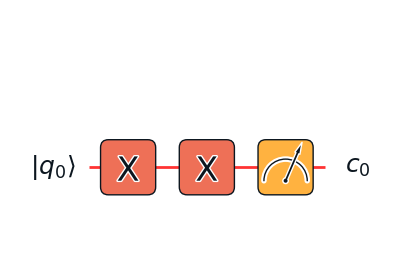

In [8]:
circ = quafuQC(1)
circ.x(0)
circ.x(0)
circ.measure([0])
circ.plot_circuit()